In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from stardist.geometry import star_dist
from tqdm import tqdm

# --- CẤU HÌNH ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 16     # U-Net++ khá nặng, nếu tràn RAM thì giảm xuống 4
EPOCHS = 100
IMG_SIZE = 256      # Kích thước ảnh (RandomCrop)
DATA_DIR = "data/train/"

print(f"🚀 Training U-Net++ (Nested U-Net) on {DEVICE}")

🚀 Training U-Net++ (Nested U-Net) on cuda


In [8]:
# --- CẤU HÌNH ---
DATA_DIR = "data/train/"  # Đường dẫn thư mục train
IMG_SIZE = 256            # Kích thước ảnh đầu vào (RandomCrop)
N_RAYS = 32               # Số tia cho StarDist
BATCH_SIZE = 8
SEED = 42

# Đặt seed để chia tập train/val cố định
torch.manual_seed(SEED)
np.random.seed(SEED)

In [9]:
def normalize_percentile(x, pmin=1, pmax=99.8, axis=None, clip=False):
    mi = np.percentile(x, pmin, axis=axis, keepdims=True)
    ma = np.percentile(x, pmax, axis=axis, keepdims=True)
    
    # --- FIX LỖI NAN: Tránh chia cho 0 nếu ảnh đồng màu ---
    if ma - mi < 1e-3: 
        return np.zeros_like(x) # Trả về ảnh đen nếu không có thông tin
        
    return (x - mi) / (ma - mi + 1e-20)

In [10]:
class UnifiedNuclearDataset(Dataset):
    def __init__(self, root_dir, mode='unet', n_rays=32, transform=None):
        """
        Args:
            mode (str): 'unet', 'unetplusplus', hoặc 'stardist'
        """
        self.root_dir = root_dir
        self.mode = mode.lower()
        self.n_rays = n_rays
        self.transform = transform
        self.ids = next(os.walk(root_dir))[1]
        
        assert self.mode in ['unet', 'unetplusplus', 'stardist'], "Mode không hợp lệ!"

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        id_ = self.ids[idx]
        path = os.path.join(self.root_dir, id_)
        
        # 1. Load Ảnh
        img_path = os.path.join(path, 'images', id_ + '.png')
        if not os.path.exists(img_path):
             img_path = os.path.join(path, 'images', os.listdir(os.path.join(path, 'images'))[0])
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Ảnh uint8

        # 2. Load Mask
        mask_dir = os.path.join(path, 'masks')
        instance_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.int32)
        
        if os.path.exists(mask_dir):
            mask_files = next(os.walk(mask_dir))[2]
            for i, f in enumerate(mask_files):
                m = cv2.imread(os.path.join(mask_dir, f), cv2.IMREAD_GRAYSCALE)
                if m is not None:
                    m = cv2.resize(m, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
                    instance_mask[m > 0] = i + 1 

        # --- [SỬA LỖI TẠI ĐÂY] ---
        # 3. Augmentation TRƯỚC (khi ảnh còn là uint8)
        if self.transform:
            # Albumentations hoạt động tốt nhất trên uint8
            aug = self.transform(image=image, mask=instance_mask)
            image = aug['image']         # Tensor (nhưng chưa normalize giá trị pixel)
            instance_mask = aug['mask']  # Tensor/Numpy

        # 4. Chuẩn hóa Percentile SAU khi Augment
        # Chuyển về numpy nếu là tensor để tính toán percentile
        if isinstance(image, torch.Tensor):
            image = image.numpy().transpose(1, 2, 0) # (C,H,W) -> (H,W,C)
            
        image = image.astype(np.float32)
        image = normalize_percentile(image)
        
        # Chuyển lại thành Tensor (C, H, W)
        image = torch.from_numpy(image).permute(2, 0, 1)

        # 5. Xử lý đầu ra theo MODE (Giữ nguyên)
        if self.mode in ['unet', 'unetplusplus']:
            binary_mask = (instance_mask > 0).float()
            if not isinstance(binary_mask, torch.Tensor):
                binary_mask = torch.from_numpy(binary_mask)
            return image, binary_mask.unsqueeze(0)

        elif self.mode == 'stardist':
            try:
                mask_np = instance_mask.numpy() if isinstance(instance_mask, torch.Tensor) else instance_mask
                distances = star_dist(mask_np, self.n_rays) 
            except:
                distances = np.zeros((IMG_SIZE, IMG_SIZE, self.n_rays), dtype=np.float32)

            object_prob = (instance_mask > 0).float()
            if not isinstance(object_prob, torch.Tensor):
                object_prob = torch.from_numpy(object_prob)

            distances = torch.from_numpy(distances).permute(2, 0, 1).float()
            return image, object_prob.unsqueeze(0), distances

In [11]:

# --- TRANSFORMS ---
train_transform = A.Compose([
    A.RandomCrop(width=IMG_SIZE, height=IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ElasticTransform(p=0.2, alpha=120, sigma=120 * 0.05),
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2()
])

val_transform = A.Compose([
    A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE),
    A.CenterCrop(height=IMG_SIZE, width=IMG_SIZE),
    ToTensorV2()
])

# --- DATALOADER ---
# mode='unetplusplus' sẽ trả về (image, binary_mask)
full_dataset = UnifiedNuclearDataset(
    root_dir=DATA_DIR, 
    mode='unetplusplus', 
    transform=train_transform
)

# Chia tập Train/Val (90/10)
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_set, val_set = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Dataset: {len(train_set)} Train samples | {len(val_set)} Val samples")

Dataset: 603 Train samples | 67 Val samples


In [12]:
import torch.nn.functional as F

class ConvBlock(nn.Module):
    """(Conv2d -> BN -> ReLU) x 2"""
    def __init__(self, in_ch, out_ch, mid_ch=None):
        super().__init__()
        if not mid_ch: mid_ch = out_ch
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, mid_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(mid_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.block(x)

In [13]:
class NestedUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision
        nb_filter = [32, 64, 128, 256, 512]
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Encoder
        self.conv0_0 = ConvBlock(in_channels, nb_filter[0])
        self.conv1_0 = ConvBlock(nb_filter[0], nb_filter[1])
        self.conv2_0 = ConvBlock(nb_filter[1], nb_filter[2])
        self.conv3_0 = ConvBlock(nb_filter[2], nb_filter[3])
        self.conv4_0 = ConvBlock(nb_filter[3], nb_filter[4])

        # Nested Layers
        self.conv0_1 = ConvBlock(nb_filter[0]+nb_filter[1], nb_filter[0])
        self.conv1_1 = ConvBlock(nb_filter[1]+nb_filter[2], nb_filter[1])
        self.conv2_1 = ConvBlock(nb_filter[2]+nb_filter[3], nb_filter[2])
        self.conv3_1 = ConvBlock(nb_filter[3]+nb_filter[4], nb_filter[3])

        self.conv0_2 = ConvBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0])
        self.conv1_2 = ConvBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1])
        self.conv2_2 = ConvBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2])

        self.conv0_3 = ConvBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0])
        self.conv1_3 = ConvBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1])

        self.conv0_4 = ConvBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0])

        # Final Output Layers (Cho Deep Supervision)
        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], out_channels, 1)
            self.final2 = nn.Conv2d(nb_filter[0], out_channels, 1)
            self.final3 = nn.Conv2d(nb_filter[0], out_channels, 1)
            self.final4 = nn.Conv2d(nb_filter[0], out_channels, 1)
        else:
            self.final = nn.Conv2d(nb_filter[0], out_channels, 1)

    def forward(self, x):
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4] # Trả về list 4 cái
        else:
            return self.final(x0_4)

In [14]:
# 1. BCEDiceLoss Cơ bản
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, pred, target):
        bce = self.bce(pred, target)
        
        pred_prob = torch.sigmoid(pred)
        intersection = (pred_prob * target).sum()
        dice = (2. * intersection + 1e-6) / (pred_prob.sum() + target.sum() + 1e-6)
        
        return 0.5 * bce + 0.5 * (1 - dice)

# 2. Deep Supervision Loss Wrapper
class DeepSupervisionLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_fn = BCEDiceLoss()

    def forward(self, inputs, target):
        # Nếu là U-Net++ (trả về list)
        if isinstance(inputs, list):
            loss = 0
            # Cộng dồn loss của 4 tầng
            for output in inputs:
                loss += self.loss_fn(output, target)
            return loss / len(inputs)
        # Nếu là U-Net thường
        else:
            return self.loss_fn(inputs, target)

In [15]:
# Khởi tạo
model = NestedUNet(in_channels=3, out_channels=1, deep_supervision=True).to(DEVICE)
loss_fn = DeepSupervisionLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.amp.GradScaler('cuda')

# Hàm tính IoU đơn giản
def get_iou(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)

history = {'train_loss': [], 'val_loss': [], 'val_iou': []}
best_iou = 0.0

print("🚀 Start Training U-Net++...")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    loop = tqdm(train_loader, desc=f"Ep {epoch+1}/{EPOCHS}")
    
    for img, mask in loop:
        img, mask = img.float().to(DEVICE), mask.float().to(DEVICE)
        
        with torch.amp.autocast('cuda'):
            preds = model(img) # List 4 outputs
            loss = loss_fn(preds, mask)
            
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()
        loop.set_postfix(loss=loss.item())
        
    # Validation
    model.eval()
    val_loss = 0
    val_iou = 0
    with torch.no_grad():
        for img, mask in val_loader:
            img, mask = img.float().to(DEVICE), mask.float().to(DEVICE)
            preds = model(img) # List 4 outputs
            
            # Tính loss
            loss = loss_fn(preds, mask)
            val_loss += loss.item()
            
            # Tính IoU (chỉ lấy output cuối cùng - tốt nhất)
            final_pred = preds[-1] if isinstance(preds, list) else preds
            val_iou += get_iou(final_pred, mask).item()
            
    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)
    
    print(f"   >> Val Loss: {avg_val_loss:.4f} | Val IoU: {avg_val_iou:.4f}")
    
    if avg_val_iou > best_iou:
        best_iou = avg_val_iou
        torch.save(model.state_dict(), "best_unet_plusplus.pth")
        print("   🔥 Saved Best Model")

🚀 Start Training U-Net++...


Ep 1/100: 100%|██████████| 76/76 [00:38<00:00,  1.99it/s, loss=0.502]


   >> Val Loss: 0.5122 | Val IoU: 0.6233
   🔥 Saved Best Model


Ep 2/100: 100%|██████████| 76/76 [00:34<00:00,  2.22it/s, loss=0.628]


   >> Val Loss: 0.4912 | Val IoU: 0.6807
   🔥 Saved Best Model


Ep 3/100: 100%|██████████| 76/76 [00:34<00:00,  2.23it/s, loss=0.466]


   >> Val Loss: 0.4646 | Val IoU: 0.6528


Ep 4/100: 100%|██████████| 76/76 [00:34<00:00,  2.22it/s, loss=0.621]


   >> Val Loss: 0.4922 | Val IoU: 0.6692


Ep 5/100: 100%|██████████| 76/76 [00:34<00:00,  2.19it/s, loss=0.437]


   >> Val Loss: 0.4254 | Val IoU: 0.7205
   🔥 Saved Best Model


Ep 6/100: 100%|██████████| 76/76 [00:34<00:00,  2.22it/s, loss=0.399]


   >> Val Loss: 0.4204 | Val IoU: 0.7242
   🔥 Saved Best Model


Ep 7/100: 100%|██████████| 76/76 [00:33<00:00,  2.28it/s, loss=0.391]


   >> Val Loss: 0.3987 | Val IoU: 0.7269
   🔥 Saved Best Model


Ep 8/100: 100%|██████████| 76/76 [00:33<00:00,  2.28it/s, loss=0.328]


   >> Val Loss: 0.3755 | Val IoU: 0.7220


Ep 9/100: 100%|██████████| 76/76 [00:33<00:00,  2.25it/s, loss=0.354]


   >> Val Loss: 0.3944 | Val IoU: 0.7035


Ep 10/100: 100%|██████████| 76/76 [00:35<00:00,  2.14it/s, loss=0.518]


   >> Val Loss: 0.3487 | Val IoU: 0.7345
   🔥 Saved Best Model


Ep 11/100: 100%|██████████| 76/76 [00:37<00:00,  2.03it/s, loss=0.255]


   >> Val Loss: 0.3277 | Val IoU: 0.7338


Ep 12/100: 100%|██████████| 76/76 [00:34<00:00,  2.21it/s, loss=0.287]


   >> Val Loss: 0.3579 | Val IoU: 0.7243


Ep 13/100: 100%|██████████| 76/76 [00:34<00:00,  2.21it/s, loss=0.338]


   >> Val Loss: 0.3070 | Val IoU: 0.7375
   🔥 Saved Best Model


Ep 14/100: 100%|██████████| 76/76 [00:34<00:00,  2.19it/s, loss=0.334]


   >> Val Loss: 0.3113 | Val IoU: 0.7153


Ep 15/100: 100%|██████████| 76/76 [00:33<00:00,  2.24it/s, loss=0.198]


   >> Val Loss: 0.3274 | Val IoU: 0.7187


Ep 16/100: 100%|██████████| 76/76 [00:33<00:00,  2.28it/s, loss=0.262]


   >> Val Loss: 0.2815 | Val IoU: 0.7224


Ep 17/100: 100%|██████████| 76/76 [00:33<00:00,  2.27it/s, loss=0.2]  


   >> Val Loss: 0.3388 | Val IoU: 0.7254


Ep 18/100: 100%|██████████| 76/76 [00:33<00:00,  2.28it/s, loss=0.373]


   >> Val Loss: 0.2793 | Val IoU: 0.7422
   🔥 Saved Best Model


Ep 19/100: 100%|██████████| 76/76 [00:33<00:00,  2.28it/s, loss=0.32] 


   >> Val Loss: 0.3354 | Val IoU: 0.7301


Ep 20/100: 100%|██████████| 76/76 [00:33<00:00,  2.25it/s, loss=0.522]


   >> Val Loss: 0.2525 | Val IoU: 0.7585
   🔥 Saved Best Model


Ep 21/100: 100%|██████████| 76/76 [00:33<00:00,  2.26it/s, loss=0.337]


   >> Val Loss: 0.2493 | Val IoU: 0.7459


Ep 22/100: 100%|██████████| 76/76 [00:33<00:00,  2.26it/s, loss=0.223]


   >> Val Loss: 0.2935 | Val IoU: 0.7451


Ep 23/100: 100%|██████████| 76/76 [00:34<00:00,  2.21it/s, loss=0.198]


   >> Val Loss: 0.2551 | Val IoU: 0.7447


Ep 24/100: 100%|██████████| 76/76 [00:34<00:00,  2.19it/s, loss=0.161]


   >> Val Loss: 0.2467 | Val IoU: 0.7402


Ep 25/100: 100%|██████████| 76/76 [00:34<00:00,  2.23it/s, loss=0.425]


   >> Val Loss: 0.2408 | Val IoU: 0.7360


Ep 26/100: 100%|██████████| 76/76 [00:33<00:00,  2.24it/s, loss=0.333] 


   >> Val Loss: 0.2396 | Val IoU: 0.7409


Ep 27/100: 100%|██████████| 76/76 [00:35<00:00,  2.14it/s, loss=0.262] 


   >> Val Loss: 0.2632 | Val IoU: 0.7404


Ep 28/100: 100%|██████████| 76/76 [00:36<00:00,  2.11it/s, loss=0.12]  


   >> Val Loss: 0.2699 | Val IoU: 0.7585
   🔥 Saved Best Model


Ep 29/100: 100%|██████████| 76/76 [00:34<00:00,  2.19it/s, loss=0.266] 


   >> Val Loss: 0.2502 | Val IoU: 0.7238


Ep 30/100: 100%|██████████| 76/76 [00:33<00:00,  2.25it/s, loss=0.143] 


   >> Val Loss: 0.2409 | Val IoU: 0.7699
   🔥 Saved Best Model


Ep 31/100: 100%|██████████| 76/76 [00:34<00:00,  2.19it/s, loss=0.514] 


   >> Val Loss: 0.2617 | Val IoU: 0.7389


Ep 32/100: 100%|██████████| 76/76 [00:33<00:00,  2.27it/s, loss=0.146] 


   >> Val Loss: 0.2191 | Val IoU: 0.7427


Ep 33/100: 100%|██████████| 76/76 [00:34<00:00,  2.22it/s, loss=0.328] 


   >> Val Loss: 0.2119 | Val IoU: 0.7414


Ep 34/100: 100%|██████████| 76/76 [00:35<00:00,  2.11it/s, loss=0.24]  


   >> Val Loss: 0.2228 | Val IoU: 0.7017


Ep 35/100: 100%|██████████| 76/76 [00:33<00:00,  2.25it/s, loss=0.111] 


   >> Val Loss: 0.2120 | Val IoU: 0.7437


Ep 36/100: 100%|██████████| 76/76 [00:34<00:00,  2.22it/s, loss=0.349] 


   >> Val Loss: 0.2176 | Val IoU: 0.7840
   🔥 Saved Best Model


Ep 37/100: 100%|██████████| 76/76 [00:36<00:00,  2.11it/s, loss=0.14]  


   >> Val Loss: 0.1955 | Val IoU: 0.7624


Ep 38/100: 100%|██████████| 76/76 [00:35<00:00,  2.12it/s, loss=0.244] 


   >> Val Loss: 0.2056 | Val IoU: 0.7428


Ep 39/100: 100%|██████████| 76/76 [00:33<00:00,  2.25it/s, loss=0.181] 


   >> Val Loss: 0.1948 | Val IoU: 0.7538


Ep 40/100: 100%|██████████| 76/76 [00:35<00:00,  2.17it/s, loss=0.103] 


   >> Val Loss: 0.1912 | Val IoU: 0.7547


Ep 41/100: 100%|██████████| 76/76 [00:36<00:00,  2.11it/s, loss=0.458] 


   >> Val Loss: 0.1929 | Val IoU: 0.7536


Ep 42/100: 100%|██████████| 76/76 [00:34<00:00,  2.21it/s, loss=0.135] 


   >> Val Loss: 0.1904 | Val IoU: 0.7449


Ep 43/100: 100%|██████████| 76/76 [00:35<00:00,  2.15it/s, loss=0.125] 


   >> Val Loss: 0.1957 | Val IoU: 0.7427


Ep 44/100: 100%|██████████| 76/76 [00:33<00:00,  2.25it/s, loss=0.435] 


   >> Val Loss: 0.2944 | Val IoU: 0.7287


Ep 45/100: 100%|██████████| 76/76 [00:34<00:00,  2.21it/s, loss=0.536] 


   >> Val Loss: 0.2138 | Val IoU: 0.7440


Ep 46/100: 100%|██████████| 76/76 [00:35<00:00,  2.14it/s, loss=0.117] 


   >> Val Loss: 0.2228 | Val IoU: 0.7466


Ep 47/100: 100%|██████████| 76/76 [00:35<00:00,  2.16it/s, loss=0.3]   


   >> Val Loss: 0.2297 | Val IoU: 0.7703


Ep 48/100: 100%|██████████| 76/76 [00:34<00:00,  2.18it/s, loss=0.309] 


   >> Val Loss: 0.2119 | Val IoU: 0.7504


Ep 49/100: 100%|██████████| 76/76 [00:34<00:00,  2.23it/s, loss=0.116] 


   >> Val Loss: 0.1853 | Val IoU: 0.7471


Ep 50/100: 100%|██████████| 76/76 [00:33<00:00,  2.25it/s, loss=0.107] 


   >> Val Loss: 0.1882 | Val IoU: 0.7496


Ep 51/100: 100%|██████████| 76/76 [00:34<00:00,  2.21it/s, loss=0.305] 


   >> Val Loss: 0.2109 | Val IoU: 0.7431


Ep 52/100: 100%|██████████| 76/76 [00:33<00:00,  2.24it/s, loss=0.0689]


   >> Val Loss: 0.1959 | Val IoU: 0.7562


Ep 53/100: 100%|██████████| 76/76 [00:33<00:00,  2.24it/s, loss=0.536] 


   >> Val Loss: 0.1921 | Val IoU: 0.7566


Ep 54/100: 100%|██████████| 76/76 [00:33<00:00,  2.24it/s, loss=0.139] 


   >> Val Loss: 0.2078 | Val IoU: 0.7566


Ep 55/100: 100%|██████████| 76/76 [00:34<00:00,  2.21it/s, loss=0.055] 


   >> Val Loss: 0.2004 | Val IoU: 0.7512


Ep 56/100: 100%|██████████| 76/76 [00:34<00:00,  2.23it/s, loss=0.629] 


   >> Val Loss: 0.1957 | Val IoU: 0.7527


Ep 57/100: 100%|██████████| 76/76 [00:33<00:00,  2.24it/s, loss=0.117] 


   >> Val Loss: 0.1807 | Val IoU: 0.7588


Ep 58/100: 100%|██████████| 76/76 [00:34<00:00,  2.23it/s, loss=0.131] 


   >> Val Loss: 0.2167 | Val IoU: 0.7492


Ep 59/100: 100%|██████████| 76/76 [00:33<00:00,  2.27it/s, loss=0.331] 


   >> Val Loss: 0.2138 | Val IoU: 0.7882
   🔥 Saved Best Model


Ep 60/100: 100%|██████████| 76/76 [00:33<00:00,  2.27it/s, loss=0.063] 


   >> Val Loss: 0.2111 | Val IoU: 0.7503


Ep 61/100: 100%|██████████| 76/76 [00:33<00:00,  2.24it/s, loss=0.43]  


   >> Val Loss: 0.1893 | Val IoU: 0.7577


Ep 62/100: 100%|██████████| 76/76 [00:34<00:00,  2.20it/s, loss=0.0894]


   >> Val Loss: 0.1676 | Val IoU: 0.7736


Ep 63/100: 100%|██████████| 76/76 [00:36<00:00,  2.10it/s, loss=0.176] 


   >> Val Loss: 0.2145 | Val IoU: 0.7608


Ep 64/100: 100%|██████████| 76/76 [00:35<00:00,  2.13it/s, loss=0.108] 


   >> Val Loss: 0.1879 | Val IoU: 0.7475


Ep 65/100: 100%|██████████| 76/76 [00:34<00:00,  2.23it/s, loss=0.126] 


   >> Val Loss: 0.1791 | Val IoU: 0.7537


Ep 66/100: 100%|██████████| 76/76 [00:35<00:00,  2.15it/s, loss=0.149] 


   >> Val Loss: 0.1912 | Val IoU: 0.7845


Ep 67/100: 100%|██████████| 76/76 [00:34<00:00,  2.19it/s, loss=0.0768]


   >> Val Loss: 0.1939 | Val IoU: 0.7604


Ep 68/100: 100%|██████████| 76/76 [00:34<00:00,  2.20it/s, loss=0.126] 


   >> Val Loss: 0.1977 | Val IoU: 0.7585


Ep 69/100: 100%|██████████| 76/76 [00:34<00:00,  2.17it/s, loss=0.106] 


   >> Val Loss: 0.1713 | Val IoU: 0.7782


Ep 70/100: 100%|██████████| 76/76 [00:33<00:00,  2.25it/s, loss=0.046] 


   >> Val Loss: 0.1992 | Val IoU: 0.7520


Ep 71/100: 100%|██████████| 76/76 [00:34<00:00,  2.18it/s, loss=0.204] 


   >> Val Loss: 0.1650 | Val IoU: 0.7925
   🔥 Saved Best Model


Ep 72/100: 100%|██████████| 76/76 [00:34<00:00,  2.19it/s, loss=0.0953]


   >> Val Loss: 0.2386 | Val IoU: 0.7562


Ep 73/100: 100%|██████████| 76/76 [00:34<00:00,  2.21it/s, loss=0.291] 


   >> Val Loss: 0.2295 | Val IoU: 0.7488


Ep 74/100: 100%|██████████| 76/76 [00:34<00:00,  2.18it/s, loss=0.214] 


   >> Val Loss: 0.2858 | Val IoU: 0.7909


Ep 75/100: 100%|██████████| 76/76 [00:34<00:00,  2.20it/s, loss=0.0852]


   >> Val Loss: 0.2204 | Val IoU: 0.7559


Ep 76/100: 100%|██████████| 76/76 [00:34<00:00,  2.23it/s, loss=0.0864]


   >> Val Loss: 0.2405 | Val IoU: 0.7957
   🔥 Saved Best Model


Ep 77/100: 100%|██████████| 76/76 [00:34<00:00,  2.20it/s, loss=0.223] 


   >> Val Loss: 0.1812 | Val IoU: 0.7787


Ep 78/100: 100%|██████████| 76/76 [00:33<00:00,  2.25it/s, loss=0.673] 


   >> Val Loss: 0.1834 | Val IoU: 0.7560


Ep 79/100: 100%|██████████| 76/76 [00:35<00:00,  2.17it/s, loss=0.0784]


   >> Val Loss: 0.1907 | Val IoU: 0.7929


Ep 80/100: 100%|██████████| 76/76 [00:34<00:00,  2.17it/s, loss=0.0952]


   >> Val Loss: 0.1870 | Val IoU: 0.7534


Ep 81/100: 100%|██████████| 76/76 [00:33<00:00,  2.24it/s, loss=0.0903]


   >> Val Loss: 0.1936 | Val IoU: 0.7572


Ep 82/100: 100%|██████████| 76/76 [00:34<00:00,  2.20it/s, loss=0.159] 


   >> Val Loss: 0.1919 | Val IoU: 0.7491


Ep 83/100: 100%|██████████| 76/76 [00:34<00:00,  2.22it/s, loss=0.343] 


   >> Val Loss: 0.1847 | Val IoU: 0.7628


Ep 84/100: 100%|██████████| 76/76 [00:34<00:00,  2.19it/s, loss=0.336] 


   >> Val Loss: 0.2380 | Val IoU: 0.7526


Ep 85/100: 100%|██████████| 76/76 [00:33<00:00,  2.27it/s, loss=0.103] 


   >> Val Loss: 0.2218 | Val IoU: 0.7632


Ep 86/100: 100%|██████████| 76/76 [00:33<00:00,  2.25it/s, loss=0.336] 


   >> Val Loss: 0.1985 | Val IoU: 0.7618


Ep 87/100: 100%|██████████| 76/76 [00:33<00:00,  2.24it/s, loss=0.0559]


   >> Val Loss: 0.1834 | Val IoU: 0.7629


Ep 88/100: 100%|██████████| 76/76 [00:36<00:00,  2.09it/s, loss=0.064] 


   >> Val Loss: 0.1992 | Val IoU: 0.7571


Ep 89/100: 100%|██████████| 76/76 [00:34<00:00,  2.18it/s, loss=0.0476]


   >> Val Loss: 0.1465 | Val IoU: 0.7964
   🔥 Saved Best Model


Ep 90/100: 100%|██████████| 76/76 [00:35<00:00,  2.16it/s, loss=0.137] 


   >> Val Loss: 0.1815 | Val IoU: 0.7779


Ep 91/100: 100%|██████████| 76/76 [00:34<00:00,  2.19it/s, loss=0.0831]


   >> Val Loss: 0.1876 | Val IoU: 0.7582


Ep 92/100: 100%|██████████| 76/76 [00:35<00:00,  2.16it/s, loss=0.138] 


   >> Val Loss: 0.1797 | Val IoU: 0.8000
   🔥 Saved Best Model


Ep 93/100: 100%|██████████| 76/76 [00:34<00:00,  2.18it/s, loss=0.0955]


   >> Val Loss: 0.1990 | Val IoU: 0.7873


Ep 94/100: 100%|██████████| 76/76 [00:34<00:00,  2.19it/s, loss=0.555] 


   >> Val Loss: 0.1720 | Val IoU: 0.7930


Ep 95/100: 100%|██████████| 76/76 [00:35<00:00,  2.16it/s, loss=0.442] 


   >> Val Loss: 0.1845 | Val IoU: 0.7561


Ep 96/100: 100%|██████████| 76/76 [00:36<00:00,  2.08it/s, loss=0.43]  


   >> Val Loss: 0.1830 | Val IoU: 0.7526


Ep 97/100: 100%|██████████| 76/76 [00:34<00:00,  2.23it/s, loss=0.213] 


   >> Val Loss: 0.1761 | Val IoU: 0.7688


Ep 98/100: 100%|██████████| 76/76 [00:34<00:00,  2.21it/s, loss=0.0429]


   >> Val Loss: 0.1967 | Val IoU: 0.7652


Ep 99/100: 100%|██████████| 76/76 [00:35<00:00,  2.16it/s, loss=0.0753]


   >> Val Loss: 0.1807 | Val IoU: 0.7597


Ep 100/100: 100%|██████████| 76/76 [00:34<00:00,  2.22it/s, loss=0.045] 


   >> Val Loss: 0.1852 | Val IoU: 0.7950


In [16]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.measure import label, regionprops
import torch

# Hàm tính IoU giữa 2 mask đơn lẻ (dùng để kiểm tra nhanh)
def compute_iou_mask(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0: return 0
    return intersection / union

In [17]:
def compute_iou_matrix(true_mask, pred_mask):
    """
    Tính ma trận IoU giữa các đối tượng trong Mask Thật và Mask Dự Đoán.
    Output: Ma trận kích thước [Số lượng True x Số lượng Pred]
    """
    # 1. Định danh các vùng rời rạc (Instance Labeling)
    # Biến ảnh nhị phân (0/1) thành ảnh định danh (0, 1, 2, 3...)
    true_labels = label(true_mask)
    pred_labels = label(pred_mask)
    
    true_objects = regionprops(true_labels)
    pred_objects = regionprops(pred_labels)
    
    # Nếu không có đối tượng nào
    if len(true_objects) == 0 or len(pred_objects) == 0:
        return np.zeros((len(true_objects), len(pred_objects)))

    # 2. Tính IoU Matrix
    # Hàng: True Objects, Cột: Pred Objects
    iou_matrix = np.zeros((len(true_objects), len(pred_objects)))
    
    for i, t_obj in enumerate(true_objects):
        # Tạo mask cho object thật thứ i
        t_mask = (true_labels == t_obj.label)
        
        # Tối ưu: Chỉ so sánh với các Pred object có bounding box giao nhau
        # (Ở đây code đơn giản sẽ so với tất cả để dễ hiểu)
        for j, p_obj in enumerate(pred_objects):
            # Kiểm tra nhanh bounding box để tránh tính toán vô ích
            if (t_obj.bbox[0] > p_obj.bbox[2] or t_obj.bbox[2] < p_obj.bbox[0] or
                t_obj.bbox[1] > p_obj.bbox[3] or t_obj.bbox[3] < p_obj.bbox[1]):
                continue
                
            p_mask = (pred_labels == p_obj.label)
            
            # Tính IoU
            intersection = np.logical_and(t_mask, p_mask).sum()
            union = np.logical_or(t_mask, p_mask).sum()
            
            if union > 0:
                iou_matrix[i, j] = intersection / union
                
    return iou_matrix

def compute_ap_from_matrix(iou_matrix, threshold):
    """
    Tính điểm AP tại 1 ngưỡng cụ thể từ IoU Matrix
    Sử dụng chiến thuật Greedy Matching (Khớp cặp có IoU cao nhất trước)
    """
    if iou_matrix.size == 0:
        return 0.0
        
    # Copy ma trận để không ảnh hưởng dữ liệu gốc
    matrix = iou_matrix.copy()
    
    num_true = matrix.shape[0]
    num_pred = matrix.shape[1]
    
    tp = 0 # True Positives
    
    # Greedy matching
    while True:
        # Tìm giá trị IoU lớn nhất trong bảng
        if matrix.max() < threshold:
            break
            
        # Lấy vị trí (hàng, cột) của giá trị max
        idx = np.unravel_index(np.argmax(matrix), matrix.shape)
        
        # Đánh dấu là khớp (TP)
        tp += 1
        
        # Loại bỏ hàng và cột này (không cho khớp với cái khác nữa)
        matrix[idx[0], :] = -1
        matrix[:, idx[1]] = -1
        
    fp = num_pred - tp # False Positives (Dự đoán thừa)
    fn = num_true - tp # False Negatives (Bỏ sót)
    
    # Công thức AP
    if tp + fp + fn == 0:
        return 0
    return tp / (tp + fp + fn)

In [18]:
def evaluate_map_range(model, loader, device):
    model.eval()
    
    # Các ngưỡng IoU: 0.5, 0.55, ..., 0.95
    thresholds = np.arange(0.5, 1.0, 0.05)
    
    # Lưu tổng AP của từng ngưỡng cho tất cả ảnh
    # Dạng: {0.5: [ap_img1, ap_img2...], 0.55: [...]}
    ap_results = {t: [] for t in thresholds}
    
    print("🚀 Đang đánh giá mAP@[0.5:0.95]...")
    
    with torch.no_grad():
        for img, _ in tqdm(loader): # Loader nên có batch_size=1
            img = img.to(device)
            
            # 1. Dự đoán
            # Output là logits
            pred_logits = model(img)
            pred_prob = torch.sigmoid(pred_logits)
            pred_mask = (pred_prob > 0.5).float().cpu().numpy().squeeze()
            
            # 2. Mask thật (cần lấy lại mask gốc từ dataset nếu có thể)
            # Ở đây ta giả định loader trả về binary mask, ta dùng label() để tách lại
            # Lưu ý: Cách này không hoàn hảo nếu ground truth bị dính nhau từ đầu
            # Nhưng với U-Net baseline thì chấp nhận được.
            
            # Để chính xác nhất, bạn nên sửa dataset để trả về Instance Mask gốc
            # Nhưng ở đây ta dùng label() lên binary mask để demo
            
            # Tái tạo lại True Mask (nếu loader trả về binary)
            # Lấy output thứ 2 của loader (mask)
            # Lưu ý: Code này giả định loader trả về (img, mask)
            # Nếu loader trả về (img, mask, ...) thì cần sửa lại
            pass 

    # --- SỬA LẠI VÒNG LẶP ĐỂ CHẠY ĐƯỢC ---
    # Chúng ta cần truy cập trực tiếp vào Dataset để lấy Instance Mask gốc (nếu có)
    # Hoặc dùng label() trên binary mask của loader
    
    # Giả sử dùng val_loader hiện tại (trả về Binary Mask)
    pass 

# VIẾT LẠI HÀM CHẠY THỰC TẾ (Dễ dùng hơn)

def run_evaluation(model, dataset, device):
    model.eval()
    thresholds = np.arange(0.5, 1.0, 0.05)
    ap_sums = {t: 0.0 for t in thresholds}
    n_images = len(dataset)
    
    print(f"Evaluating on {n_images} images...")
    
    for i in tqdm(range(n_images)):
        # Lấy dữ liệu từ dataset
        img_tensor, true_mask_tensor = dataset[i]
        
        # Chuyển mask thật về numpy 2D (H, W)
        true_mask = true_mask_tensor.squeeze().numpy()
        true_mask = (true_mask > 0).astype(int)
        
        # --- SỬA LỖI TẠI ĐÂY: Thêm .float() ---
        # Ép kiểu về float32 trước khi đưa vào device
        img_input = img_tensor.unsqueeze(0).float().to(device)
        
        with torch.no_grad():
            pred = model(img_input)
            pred = torch.sigmoid(pred)
            pred_mask = (pred > 0.5).float().cpu().numpy().squeeze()
            
        # Tính IoU Matrix
        matrix = compute_iou_matrix(true_mask, pred_mask)
        
        # Tính AP tại các ngưỡng
        for t in thresholds:
            ap = compute_ap_from_matrix(matrix, t)
            ap_sums[t] += ap
            
    # Tính trung bình
    map_results = {k: v / n_images for k, v in ap_sums.items()}
    return map_results

✅ Đã load thành công model U-Net++ từ 'best_unet_plusplus.pth'
✅ Đã tạo val_set với 67 ảnh cho U-Net++.
Evaluating on 67 images...


100%|██████████| 67/67 [00:10<00:00,  6.50it/s]



 KẾT QUẢ mAP@[0.5:0.95] (U-Net++ Deep Supervision)
 IoU Threshold  AP Score
          0.50  0.760749
          0.55  0.730567
          0.60  0.717197
          0.65  0.682647
          0.70  0.662875
          0.75  0.620953
          0.80  0.559957
          0.85  0.445150
          0.90  0.301683
          0.95  0.143599
----------------------------------------
Mean AP (mAP): 0.5625


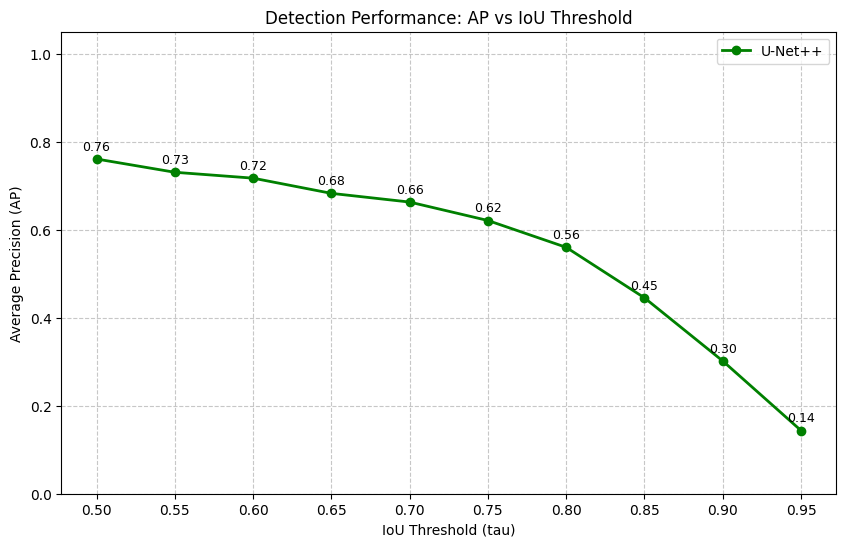

In [19]:
import torch
from torch.utils.data import random_split
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. MODEL WRAPPER (Xử lý đầu ra U-Net++) ---
# Class này giúp lấy output cuối cùng từ list 4 output của U-Net++
class UnetPlusPlusInference(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def forward(self, x):
        outputs = self.model(x)
        # Nếu model trả về list (Deep Supervision), lấy cái cuối cùng (L4)
        if isinstance(outputs, list):
            return outputs[-1]
        return outputs

# --- 2. KHỞI TẠO VÀ LOAD MODEL ---
# Khởi tạo kiến trúc NestedUNet (phải khớp với lúc train: deep_supervision=True)
base_model = NestedUNet(in_channels=3, out_channels=1, deep_supervision=True).to(DEVICE)

# Load trọng số
checkpoint_path = "best_unet_plusplus.pth" # Tên file bạn đã lưu khi train U-Net++

try:
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
        base_model.load_state_dict(checkpoint['state_dict'])
    else:
        base_model.load_state_dict(checkpoint)
    print(f"✅ Đã load thành công model U-Net++ từ '{checkpoint_path}'")
except FileNotFoundError:
    print(f"❌ Không tìm thấy file '{checkpoint_path}'. Hãy kiểm tra lại tên file.")

# Bọc model lại để dùng cho hàm đánh giá
model = UnetPlusPlusInference(base_model)
model.eval()

# --- 3. TẠO TẬP DỮ LIỆU (Mode = 'unetplusplus') ---
# Dùng mode='unetplusplus' (hoặc 'unet' cũng được vì mask giống nhau)
full_dataset = UnifiedNuclearDataset(
    root_dir=DATA_DIR, 
    mode='unetplusplus', 
    n_rays=N_RAYS, 
    transform=val_transform 
)

# Chia tập dữ liệu (Giống hệt lúc train)
generator = torch.Generator().manual_seed(SEED)
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size

_, val_set = random_split(full_dataset, [train_size, val_size], generator=generator)

print(f"✅ Đã tạo val_set với {len(val_set)} ảnh cho U-Net++.")

# --- 4. CHẠY ĐÁNH GIÁ ---
# Hàm run_evaluation sẽ hoạt động bình thường nhờ UnetPlusPlusInference wrapper
metrics = run_evaluation(model, val_set, DEVICE)

# --- 5. HIỂN THỊ KẾT QUẢ ---
print("\n" + "="*40)
print(" KẾT QUẢ mAP@[0.5:0.95] (U-Net++ Deep Supervision)")
print("="*40)

# Tạo bảng
df = pd.DataFrame(list(metrics.items()), columns=['IoU Threshold', 'AP Score'])
print(df.to_string(index=False))

print("-" * 40)
print(f"Mean AP (mAP): {df['AP Score'].mean():.4f}")

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(df['IoU Threshold'], df['AP Score'], 'g-o', linewidth=2, label='U-Net++')
plt.title('Detection Performance: AP vs IoU Threshold')
plt.xlabel('IoU Threshold (tau)')
plt.ylabel('Average Precision (AP)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(df['IoU Threshold'])
plt.ylim(0, 1.05)
plt.legend()

# Thêm nhãn giá trị
for x, y in zip(df['IoU Threshold'], df['AP Score']):
    plt.text(x, y + 0.02, f"{y:.2f}", ha='center', fontsize=9)

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.20320855614973263..1.0641711229946524].


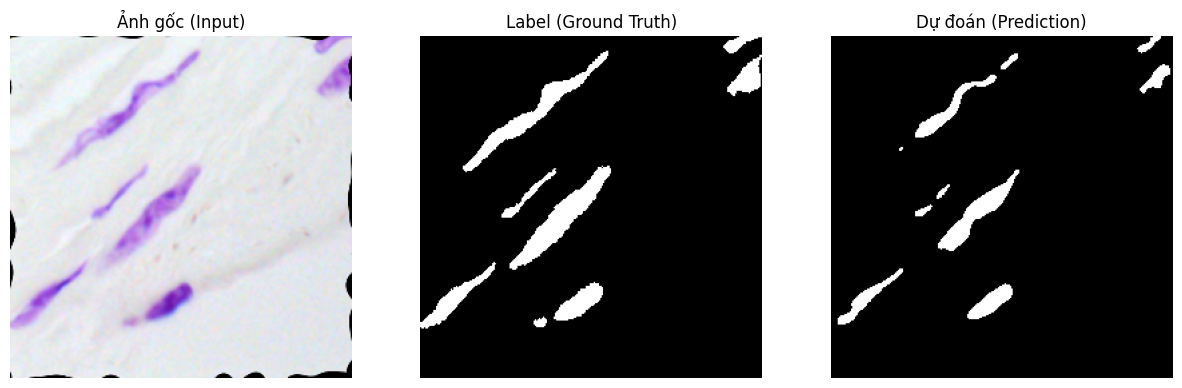

In [20]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# 1. Lấy 1 batch dữ liệu từ val_loader
# (Đảm bảo val_loader đã được khởi tạo thành công trước đó)
data, targets = next(iter(val_loader))

# 2. Đưa vào thiết bị và ép kiểu float (QUAN TRỌNG để tránh lỗi DoubleTensor)
inputs = data.float().to(DEVICE)

# 3. Chạy mô hình dự đoán
model.eval()
with torch.no_grad():
    preds = model(inputs)
    preds = torch.sigmoid(preds)     # Chuyển logits thành xác suất (0-1)
    preds = (preds > 0.5).float()    # Chuyển thành nhị phân (0 hoặc 1)

# 4. Lấy mẫu đầu tiên trong batch để hiển thị
# Chuyển tensor về numpy: (C, H, W) -> (H, W, C) cho ảnh màu
img = data[0].permute(1, 2, 0).cpu().numpy()
mask = targets[0].squeeze().cpu().numpy()
pred = preds[0].squeeze().cpu().numpy()

# 5. Vẽ hình
plt.figure(figsize=(15, 5))

# Ảnh gốc
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Ảnh gốc (Input)")
plt.axis("off")

# Ảnh Label (Đáp án)
plt.subplot(1, 3, 2)
plt.imshow(mask, cmap="gray")
plt.title("Label (Ground Truth)")
plt.axis("off")

# Ảnh Dự đoán
plt.subplot(1, 3, 3)
plt.imshow(pred, cmap="gray")
plt.title("Dự đoán (Prediction)")
plt.axis("off")

plt.show()